# Customer Segmentation

## Background

This dataset contains all purchases made for an online retail company based in the UK during an eight month period. We could use cluster analysis combined with RFM analysis to do a customer segmentation.

## Prepare and Explore the Data

For this experiment, we will use [this](https://www.kaggle.com/vijayuv/onlineretail) data from Kaggle platform.

In [ ]:
# Package imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', None)

In [ ]:
# Load data
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Since we want to segment our customers, we have to make sure that `CustomerID` is not null.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
# Check missing value
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

We could see that there is missing value in `CustomerID` columns. We could remove those missing values.

In [ ]:
for col in df.columns:
  pct_missing = np.mean(df[col].isnull())
  print('{} - {}%'.format(col, pct_missing))

InvoiceNo - 0.0%
StockCode - 0.0%
Description - 0.002683107311375157%
Quantity - 0.0%
InvoiceDate - 0.0%
UnitPrice - 0.0%
CustomerID - 0.249266943342886%
Country - 0.0%


In [ ]:
# Remove missing value
df = df[df["CustomerID"].notna()]

df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Then we could do some descriptive statistic.

In [ ]:
df.shape[0]

406829

In [ ]:
# Simple descriptive statistic
df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


Wait, hold on. How come the quantity is a negative number and the unit price is zero? Let's check it.

In [ ]:
# Check anomaly data
quantity_zero = len(df[df["Quantity"] <= 0])
perc_quantity_zero = (len(df[df["Quantity"] <= 0]) / len(df)) * 100
unitprice_zero = len(df[df["UnitPrice"] == 0])
perc_unitprice_zero = (len(df[df["UnitPrice"] == 0]) / len(df)) * 100

print("The data consist of", str(quantity_zero), "rows of data with item quantity less/equal than zero.")
print("About {:.2f}% of total data".format(perc_quantity_zero))
print("")
print("The data consist of", str(unitprice_zero), "rows of data with unit price equal to zero.")
print("About {:.2f}% of total data".format(perc_unitprice_zero))

The data consist of 8905 rows of data with item quantity less/equal than zero.
About 2.19% of total data

The data consist of 40 rows of data with unit price equal to zero.
About 0.01% of total data


Then just remove those anomaly data

In [ ]:
# Remove anomaly
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,397884.000000,397884.000000
mean,12.988238,3.116488
std,179.331775,22.097877
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


Now we're good to go. Lets do some data exploration!

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


The data contains 406829 rows and 8 columns, each row represents each item in a purchasement. The columns are:
* `InvoiceNo` - Invoice number, to identify each invoice
* `StockCode` - Stock code, to identify each item in the inventory
* `Description` - Item's description
* `Quantity` - Number of purchased item in each invoice
* `InvoiceDate` - Date of purchasement
* `UnitPrice` - Item's price per unit
* `CustomerID` - Customer's identification number
* `Country` - Customer's country of origin

In [ ]:
# Check unique value
df[['InvoiceNo', 'StockCode', 'CustomerID', 'Country']].nunique()

InvoiceNo     18532
StockCode      3665
CustomerID     4338
Country          37
dtype: int64

There are 18532 purchasements, 3665 unique item purchased, from 4338 customers that came from 37 countries.

As we seen above, there are 37 countries of customer's origin. Since the retail company is based in the UK, we could simplified the country as UK or Non UK

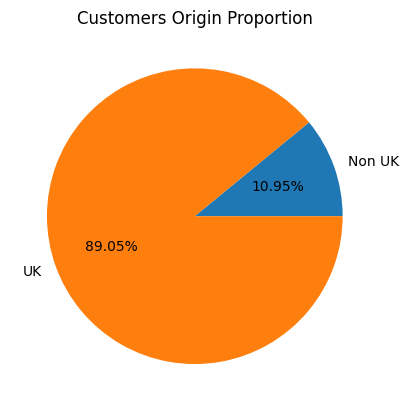

In [ ]:
# Simplify country origin
df['Country_isUK'] = np.where(df['Country']=='United Kingdom', 'UK', 'Non UK')

customers_origin = df.groupby(['Country_isUK']).size()

plt.title('Customers Origin Proportion')
plt.pie(customers_origin, labels=customers_origin.index, autopct=lambda p: f'{p:.2f}%')
plt.show();

Based on the piechart, we could see that mostly our customers are from the UK.

Next, we could analyze the trend of purchasement. First, lets create `TotalAmount` column (`Quantity` * `UnitPrice`). Then, we could transform the `InvoiceDate` data type from string to date.

In [ ]:
# Create new features and cast date column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34


In [ ]:
df['Country'].value_counts()

United Kingdom          354321
Germany                   9040
France                    8341
EIRE                      7236
Spain                     2484
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1462
Australia                 1182
Norway                    1071
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45
Lithuani

Then plot the trendline.

In [ ]:
import matplotlib.dates as mdates

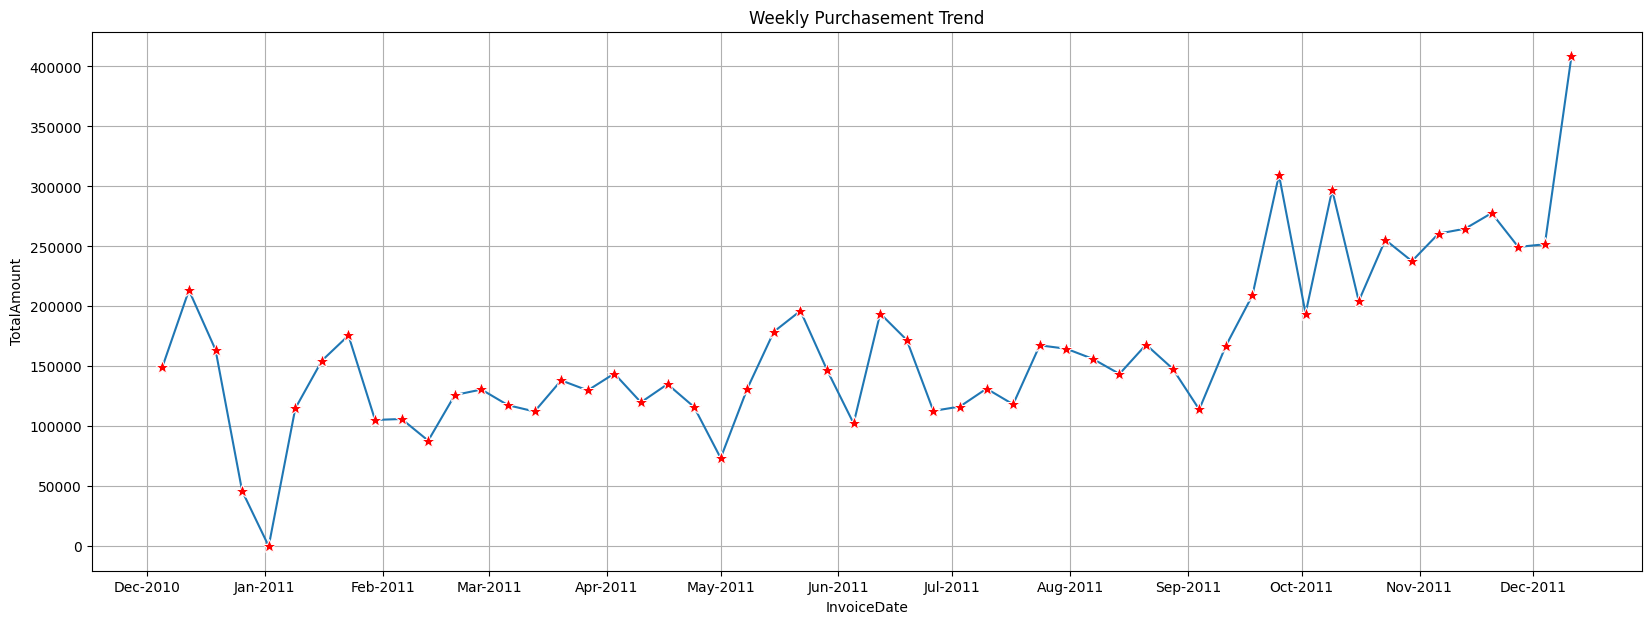

In [ ]:
# Plot weekly trend
weekly_purchasements = df.copy()
weekly_purchasements = weekly_purchasements.groupby(
    by=pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Weekly Purchasement Trend')
ax = sns.lineplot(
    x=weekly_purchasements.index,
    y=weekly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

In [ ]:
weekly_purchasements = df.copy()
weekly_purchasements = weekly_purchasement.groupby(by=pd.Grouper(key='InvoiceDate', freq='1M'))['TotalAmount'].sum()
plt.figure(figsize=(20, 7))
plt.title('Weeklyb Purchasements Trend')
ax= sns.lineplot(data=weekly_purchasements,
                 x=weekly_purchasement.index,
                 y=weekly_purchasement,
                 marker='o',
                 markersize=12,
                 markerfacecolor='red')
ax.xaxis.set_major_locater(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show()

NameError: ignored

In [ ]:
# Plot monthly trend
monthly_purchasements = df.copy()
monthly_purchasements = monthly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Monthly Purchasement Trend')
ax = sns.lineplot(
    x=monthly_purchasements.index,
    y=monthly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

Based on the picture above, it can be seen that there was an increase in total purchases at the end of the year.

## RFM

In this project, we would segment the customers using customer's demography and purchasement behavior. To explain the customer's demography, we could use `Country` column while to explain the customer's purchasement behavior we have to transform our data first to get those information. We could use RFM analysis to get those information.

### Recency

To measure customer's recency, we could substract the latest transaction date in the data with each customer's latest transaction.

In [ ]:
# Get customer's recency
recency = df.groupby(['CustomerID'])['InvoiceDate'].max()
recency = max(recency) - recency
recency = recency.dt.days
recency = recency.rename('Recency')

recency.head()

CustomerID
12346.0    325
12347.0      1
12348.0     74
12349.0     18
12350.0    309
Name: Recency, dtype: int64

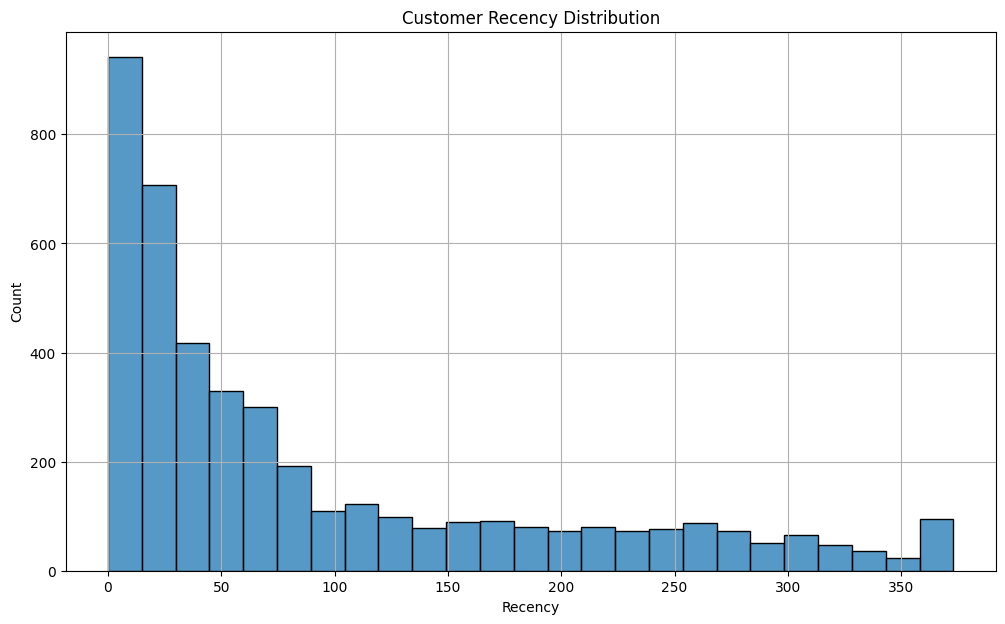

In [ ]:
# Recency histogram plot
plt.figure(figsize=(12, 7))
sns.histplot(recency)
plt.title('Customer Recency Distribution')
plt.grid()
plt.show()

### Frequency

To measure customer's frequency, we could count customer's invoice.

In [ ]:
# Count frequency
frequency = df.groupby(['CustomerID'])['InvoiceNo'].count()
frequency = frequency.rename('Frequency')
frequency.head()

CustomerID
12346.0      1
12347.0    182
12348.0     31
12349.0     73
12350.0     17
Name: Frequency, dtype: int64

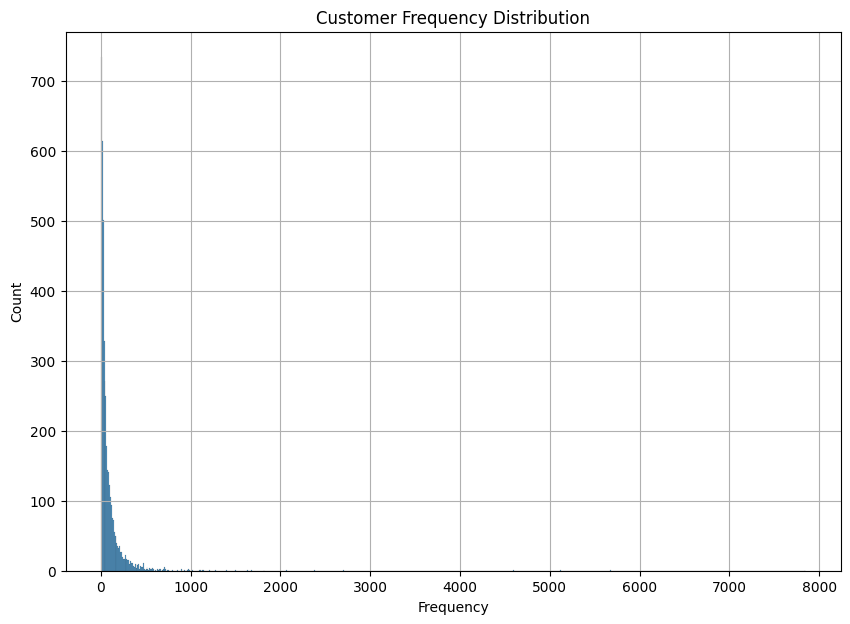

In [ ]:
# Frequency histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Frequency Distribution')
sns.histplot(frequency)
plt.grid()
plt.show();

### Monetary

To measure customer's monetary, we could sum the customer's total purchasements.

In [ ]:
# Sum the money spent
monetary = df.groupby(['CustomerID'])['TotalAmount'].sum()
monetary = monetary.rename('Monetary')
monetary.head()

CustomerID
12346.0    77183.60
12347.0     4310.00
12348.0     1797.24
12349.0     1757.55
12350.0      334.40
Name: Monetary, dtype: float64

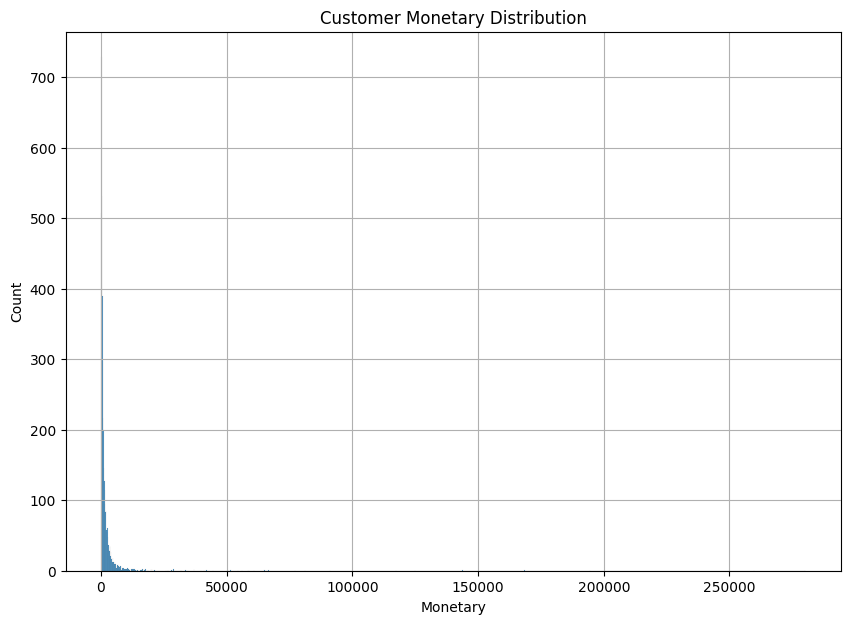

In [ ]:
# Monetary histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Monetary Distribution')
sns.histplot(monetary)
plt.grid()
plt.show()

### Merge the Data

The data could be separated into two dataframes. The first dataframe (log transformed data) supposed to be used when modeling and the second one (without log transformation) could be used when visualize the result.

In [ ]:
# Get customer's country of origin
country = (
    df.groupby(['CustomerID', 'Country_isUK'])
    .size()
    .reset_index()
    .drop(0, axis=1)
)

# Merge the data
df_new = (
    country
    .merge(recency, on='CustomerID')
    .merge(frequency, on='CustomerID')
    .merge(monetary, on='CustomerID')
)

# Set CustomerID as index
df_new = df_new.set_index('CustomerID')
df_new.head()

,Country_isUK,Recency,Frequency,Monetary
CustomerID,,,,
12346.0,UK,325,1,77183.60
12347.0,Non UK,1,182,4310.00
12348.0,Non UK,74,31,1797.24
12349.0,Non UK,18,73,1757.55
12350.0,Non UK,309,17,334.40


### One Hot Encoding

Since our model could just accept the numeric value, we have to recode the non numeric column.

In [ ]:
# Recode the non numeric variable

df_new = pd.get_dummies(
    df_new,
    columns=['Country_isUK'],
    drop_first=True
)

df_new = df_new.rename(
    columns={'Country_isUK_UK': 'Country_UK'}
)

df_new.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,325,1,77183.60,1
12347.0,1,182,4310.00,0
12348.0,74,31,1797.24,0
12349.0,18,73,1757.55,0
12350.0,309,17,334.40,0


### Scaling

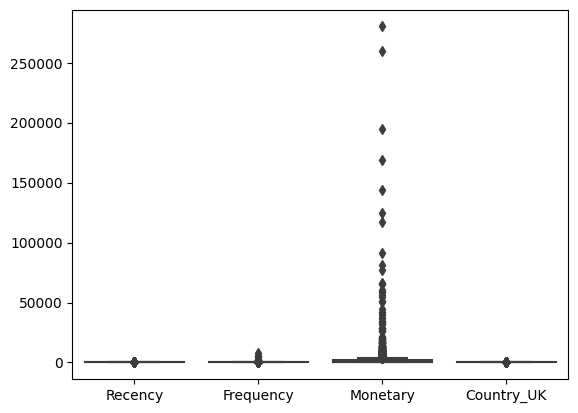

In [ ]:
sns.boxplot(data=df_new)
plt.show()

As we could see, there are variation of range in each column. We have to standardize it first.

In [ ]:
# Scale the data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new)

df_scaled = pd.DataFrame(
    df_scaled,
    columns=df_new.columns,
    index=df_new.index
)

df_scaled.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,2.334574,-0.396578,8.358668,0.326547
12347.0,-0.905340,0.394649,0.250966,-3.062350
12348.0,-0.175360,-0.265435,-0.028596,-3.062350
12349.0,-0.735345,-0.081836,-0.033012,-3.062350
12350.0,2.174578,-0.326635,-0.191347,-3.062350


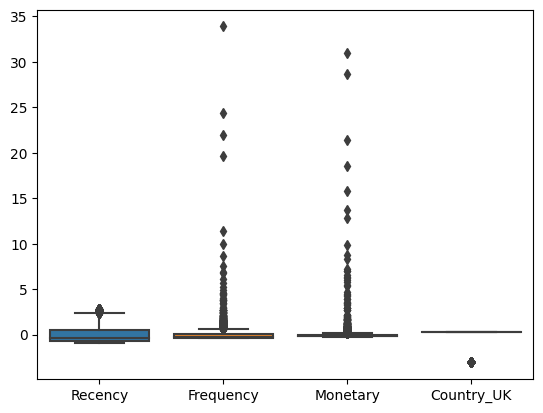

In [ ]:
# Plot scaled data
sns.boxplot(data = df_scaled)
plt.show()

## Modeling

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Modeling
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette = []

for k in possible_k:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_scaled)
    silhouette.append(silhouette_score(X=df_scaled, labels=kmeans.labels_))

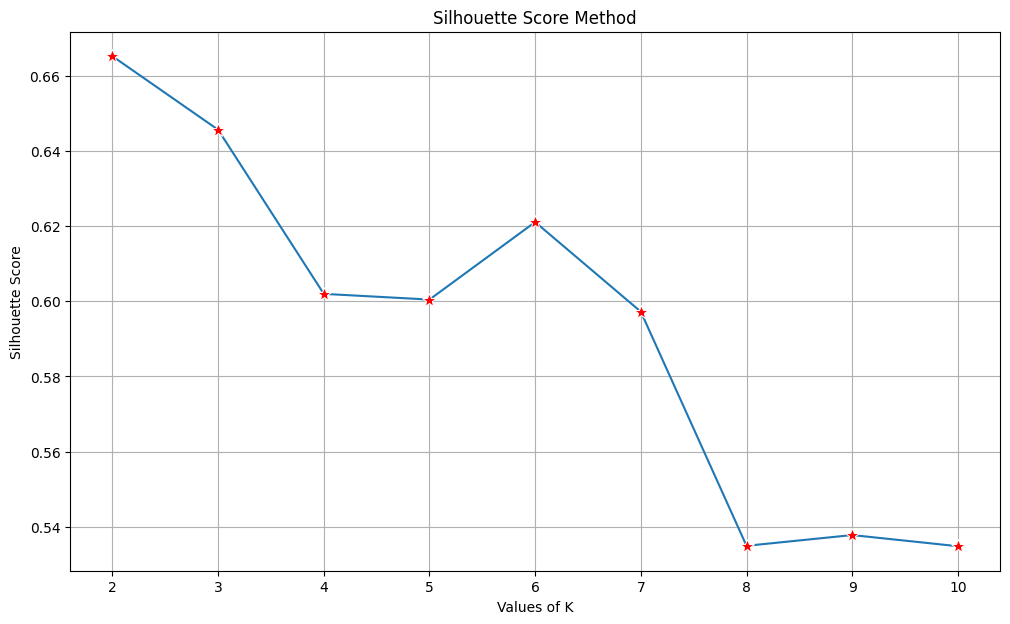

In [ ]:
# Plot the score
plt.figure(figsize=(12, 7))
sns.lineplot(
    x=possible_k,
    y=silhouette,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.grid()
plt.show();

Using silhouette score, the best K is either 2 or 6

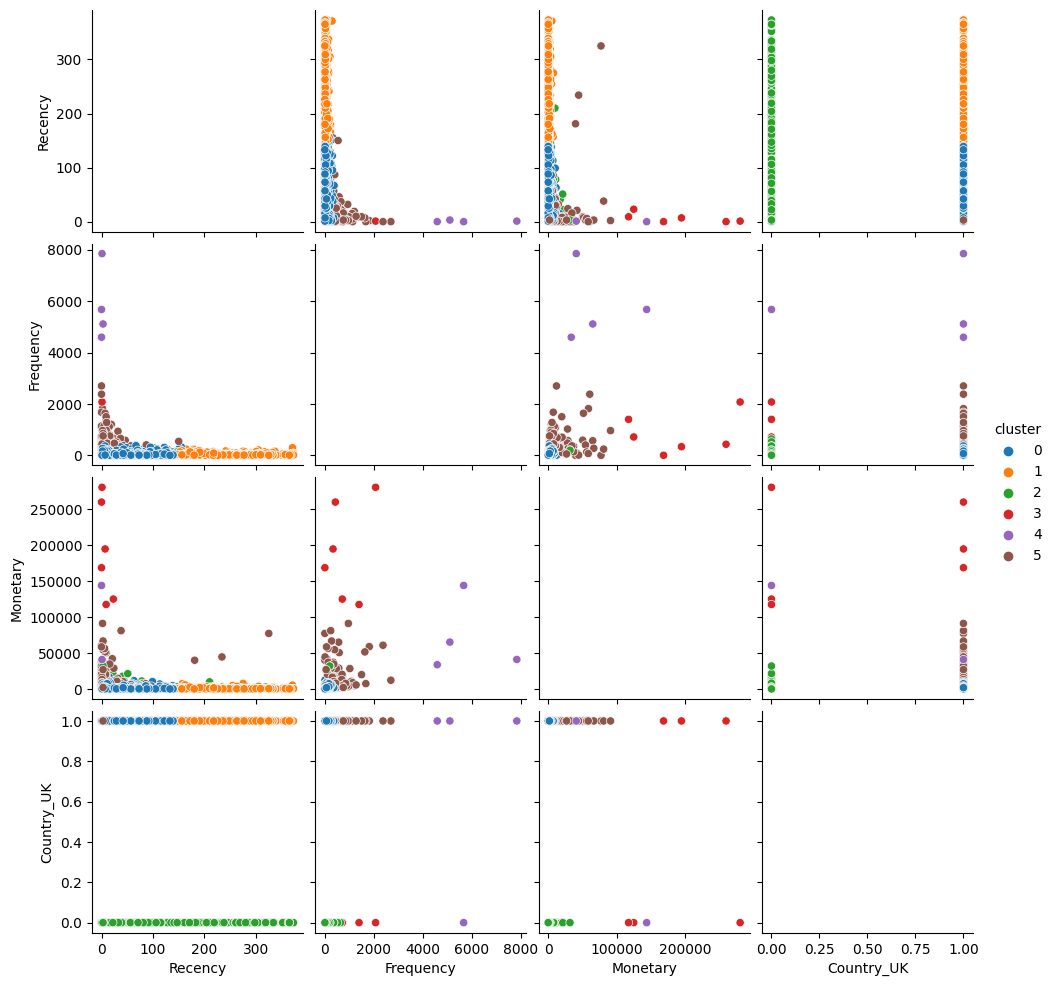

In [ ]:
kmeans = KMeans(
    n_clusters=6,
    random_state=42).fit(df_scaled)

df_result_kmeans = df_new.copy()
df_result_kmeans['cluster'] = kmeans.labels_

sns.pairplot(
    data=df_result_kmeans,
    hue='cluster',
    diag_kind='None',
    palette='tab10'
)

plt.show();

In [ ]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
(
    df_result_kmeans
    .drop("Country_UK", axis = 1)
    .groupby('cluster')
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max'])
    .transpose()
)

cluster                      0            1             2              3  \
Recency   mean       42.676884   246.776618     95.405797       6.666667   
          std        36.313016    65.636727    104.638705       8.869423   
          min         0.000000   143.000000      0.000000       0.000000   
          q25        14.000000   189.000000     18.000000       0.250000   
          median     31.000000   242.000000     52.000000       4.000000   
          q75        64.000000   296.000000    136.500000       8.500000   
          max       155.000000   373.000000    373.000000      23.000000   
Frequency mean       76.270826    27.689979     81.396135     826.833333   
          std        74.030983    32.176026     96.304061     771.620481   
          min         1.000000     1.000000      1.000000       3.000000   
          q25        22.000000     8.250000     21.250000     360.500000   
          median     51.000000    18.000000     45.000000     572.500000   
          q75       107.000000    33.000000    101.000000    1228.500000   
          max       385.000000   297.000000    638.000000    2076.000000   
Monetary  mean     1341.293935   450.793070   2262.538913  190863.461667   
          std      1592.871914   610.367153   3479.689136   67791.993010   
          min         6.200000     3.750000     51.560000  117379.630000   
          q25       371.700000   163.225000    459.650000  135804.022500   
          median    795.120000   305.515000   1025.700000  181511.645000   
          q75      1720.300000   505.542500   2659.962500  243380.672500   
          max     17654.540000  7832.470000  31906.820000  280206.020000   

cluster                       4             5  
Recency   mean         1.000000     15.234973  
          std          1.414214     35.305176  
          min          0.000000      0.000000  
          q25          0.000000      2.000000  
          median       0.500000      6.000000  
          q75          1.500000     16.000000  
          max          3.000000    325.000000  
Frequency mean      5807.000000    535.360656  
          std       1429.730044    358.078267  
          min       4595.000000      1.000000  
          q25       4982.000000    367.000000  
          median    5393.000000    450.000000  
          q75       6218.000000    589.500000  
          max       7847.000000   2700.000000  
Monetary  mean     70925.287500  13085.065738  
          std      50424.336433  16313.461152  
          min      33719.730000   1093.650000  
          q25      39173.610000   4014.945000  
          median   53078.180000   6923.130000  
          q75      84829.857500  13213.210000  
          max     143825.060000  91062.380000

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Recency"].count()

cluster  Country_UK
0        1             2773
1        1              958
2        0              414
3        0                3
         1                3
4        0                1
         1                3
5        1              183
Name: Recency, dtype: int64

That's it! The customer's behavior really segmented by their country of origin.

What if we separate the customer by its country of origin before doing cluster analysis?

# Question

# Customer dengan pembelian terbanyak

1. (30 point) Lakukan EDA lebih mendalam dari data yang tersedia. Misalnya: a) Siapa top 5 customer dengan pembelian terbanyak? b) Kapan waktu pembelian dengan jumlah customer terbanyak? (Misal hari apa, jam berapa, bulan apa, minggu ke berapa, dst). EDA juga bisa dilakukan menggunakan business question lain.
2. (40 point) Bagaimana jika segmentation difokuskan untuk customer di luar UK? Apakah terdapat insight yang menarik? Apa karakteristik utama dari cluster-cluster non UK?

1.A. Customer dengan pembelian terbanyak


Top 5 Konsumen pembelian terbanyak:
CustomerID
17841.0    7847
14911.0    5675
14096.0    5111
12748.0    4595
14606.0    2700
Name: InvoiceNo, dtype: int64


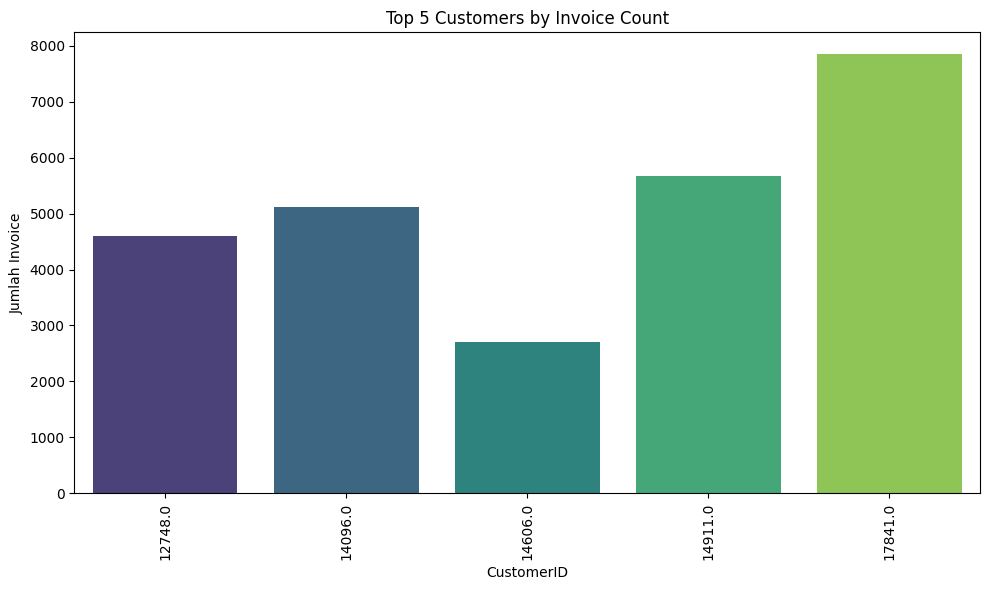

In [ ]:
top_5 = df.groupby('CustomerID')['InvoiceNo'].count().nlargest(5)
print('\nTop 5 Konsumen pembelian terbanyak:')
print(top_5)
top_5 = top_5.reset_index()
top_5 = top_5.sort_values(by=['InvoiceNo'], ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(data=top_5, x='CustomerID', y='InvoiceNo', palette='viridis')
plt.title('Top 5 Customers by Invoice Count')
plt.xlabel('CustomerID')
plt.ylabel('Jumlah Invoice')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


1B. Konsumen dengan Jam, Minggu, Bulan pembelian terbanyak.


In [ ]:
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['Hour'] = df['InvoiceDate'].dt.hour

frequent_time = df.groupby(['YearMonth', 'DayOfWeek', 'Hour'])['CustomerID'].nunique().idxmax()

print("Year-Month:", frequent_time[0])
print("Day of Week:", frequent_time[1])
print("Hour:", frequent_time[2])

Year-Month: 2011-11
Day of Week: Tuesday
Hour: 12


**Konsumen dengan pembelian terbanyak pada jam 12 hari Selasa bulan November tahun 2011 **

In [ ]:
df_result_kmeans.Frequency.quantile([0.25, 0.5, 0.75])

0.25     17.0
0.50     41.0
0.75    100.0
Name: Frequency, dtype: float64

In [ ]:
def freq(freq_score):
  if freq_score < 17:
    return 'Low_F'
  elif 17 <= freq_score < 41:
    return 'Mid_F'
  elif 41 <= freq_score < 75:
    return 'High_F'
  else:
    return 'Very_High_F'

df_result_kmeans['Frequency_Category'] = df_result_kmeans['Frequency'].apply(freq)
df_result_kmeans.head()

,Recency,Frequency,Monetary,Country_UK,cluster,Frequency_Category
CustomerID,,,,,,
12346.0,325,1,77183.60,1,5,Low_F
12347.0,1,182,4310.00,0,2,Very_High_F
12348.0,74,31,1797.24,0,2,Mid_F
12349.0,18,73,1757.55,0,2,High_F
12350.0,309,17,334.40,0,2,Mid_F


# Karakterisitik Setiap Cluster Beserta Ide Promosi

CLUSTER 0

Recency: Cluster ini memiliki rata-rata recency sekitar 42 hari.
Frequency: Pelanggan cluster ini memiliki rata-rata frekuensi transaksi 76 kali.
Monetary: Pelanggan cluster ini memiliki transaksi moneter dengan nilai yang cukup rendah, dengan nilai moneter rata-rata sebesar 1.341,29.

Ide Promosi:
- Memberikan voucher diskon bulanan setiap user log in per bulan.
- Memberikan program loyalitas atau membership.

CLUSTER 1

Recency: Cluster ini recency nya cenderung tidak aktif yang memiliki rata-rata recency sekitar 247 hari.
Frequency: Pelanggan cluster ini memiliki rata-rata frekuensi transaksi 28 kali.
Monetary: Pelanggan cluster ini memiliki transaksi moneter dengan nilai yang rendah, dengan nilai moneter rata-rata sebesar 450,79.

Ide Promosi:
- Memberikan program loyalitas agar konsumen aktif kembali.
- Pemberian diskon untuk pembelian barang tertentu.

CLUSTER 2

Recency: Cluster ini recency nya cukup aktif yang memiliki rata-rata recency sekitar 95 hari.
Frequency: Pelanggan cluster ini memiliki rata-rata frekuensi transaksi 81 kali.
Monetary: Pelanggan cluster ini memiliki transaksi moneter dengan nilai yang cukup rendah, dengan nilai moneter rata-rata sebesar 2.262,54.

Ide Promosi:
- Memberikan voucher diskon untuk pembelian barang tertentu.
- Memberikan potongan ongkos kirim untuk pembelian diatas barang tertentu.


CLUSTER 3

Recency: Cluster ini recency nya aktif yang memiliki rata-rata recency sekitar 7 hari.
Frequency: Pelanggan cluster ini memiliki rata-rata frekuensi transaksi 827 kali pembelian.
Monetary: Pelanggan cluster ini memiliki transaksi moneter dengan nilai yang tinggi, dengan nilai moneter rata-rata sebesar 190.863,46.

Ide Promosi:
- Memberikan potongan berupa cashback setiap transaksi barang tertentu.
- Memberikan diskon khusus untuk pembelian barang selanjutnya.

CLUSTER 4
Recency: Cluster ini recency nya sangat aktif yang memiliki rata-rata recency sekitar 1 hari.
Frequency: Pelanggan cluster ini memiliki rata-rata frekuensi transaksi 5.807,00 kali pembelian.
Monetary: Pelanggan cluster ini memiliki transaksi moneter dengan nilai yang sedang, dengan nilai moneter rata-rata sebesar 70.925,29.

Ide Promosi:
- Memberikan reward berupa point untuk setiap transaksi.
- Pemberian gratis ongkos kirim untuk pembelian diatas barang tertentu.

CLUSTER 5
Recency: Cluster ini recency nya cukup aktif yang memiliki rata-rata recency sekitar 15 hari.
Frequency: Pelanggan cluster ini memiliki rata-rata frekuensi transaksi 535 kali pembelian.
Monetary: Pelanggan cluster ini memiliki transaksi moneter dengan nilai yang sedang, dengan nilai moneter rata-rata sebesar 13.085,07.

Ide Promosi:
- Memberikan voucher diskon untuk pembelian besar.
- Meberikan gratis ongkos kirim untuk pembelian diatas barang tertentu.


# Segmentasi jika difokuskan pada negara non UK

3. Segmentasi jika difokuskan pada negara non UK

In [ ]:
non_uk_countries = df[df['Country'] != 'United Kingdom']['Country'].unique()

# Menampilkan negara-negara non-UK
print("Negara-negara Non-UK:")
for country in non_uk_countries:
    print(country)

Negara-negara Non-UK:
France
Australia
Netherlands
Germany
Norway
EIRE
Switzerland
Spain
Poland
Portugal
Italy
Belgium
Lithuania
Japan
Iceland
Channel Islands
Denmark
Cyprus
Sweden
Finland
Austria
Greece
Singapore
Lebanon
United Arab Emirates
Israel
Saudi Arabia
Czech Republic
Canada
Unspecified
Brazil
USA
European Community
Bahrain
Malta
RSA


In [ ]:
#Melakukan analisis KMeans untuk negara non-UK
X_non_uk = df_new[df_new['Country_UK'] == 0][['Recency', 'Frequency', 'Monetary']]

#Melakukan scaling
scaler = StandardScaler()
X_non_uk_scaled = scaler.fit_transform(X_non_uk)



In [ ]:
#modelling menggunakan silhouette
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette = []

for k in possible_k:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_non_uk_scaled)
    silhouette.append(silhouette_score(X=X_non_uk_scaled, labels=kmeans.labels_))

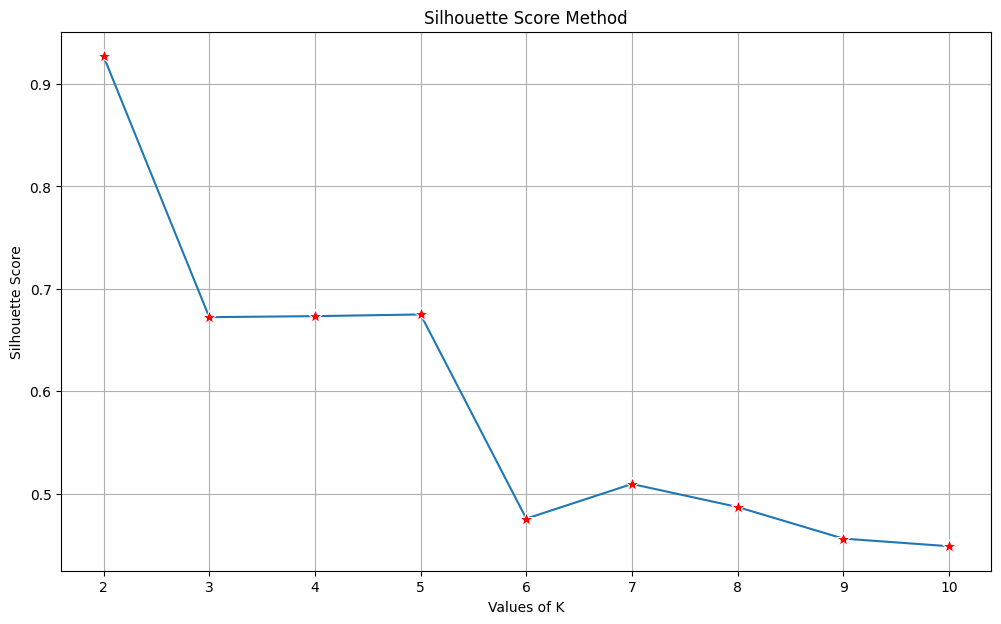

In [ ]:
# Plot the score
plt.figure(figsize=(12, 7))
sns.lineplot(
    x=possible_k,
    y=silhouette,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.grid()
plt.show();

In [ ]:
kmeans_non_uk = KMeans(n_clusters=3, random_state=42)
labels_non_uk = kmeans_non_uk.fit_predict(X_non_uk_scaled)

# Menampilkan label kluster ke dalam DataFrame X_non_uk
X_non_uk['Cluster'] = labels_non_uk
X_non_uk.head()


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12347.0,1,182,4310.00,2
12348.0,74,31,1797.24,2
12349.0,18,73,1757.55,2
12350.0,309,17,334.40,1
12352.0,35,85,2506.04,2


In [ ]:
clusters_non_uk = (
    X_non_uk
    .groupby('Cluster')
    .agg({'Recency': ['mean', 'std', 'min', q25, 'median', q75, 'max'],
          'Frequency': ['mean', 'std', 'min', q25, 'median', q75, 'max'],
          'Monetary': ['mean', 'std', 'min', q25, 'median', q75, 'max']})
)

# Cetak karakteristik dari masing-masing cluster non UK
print("\nKarakteristik  Masing-Masing Cluster untuk negara Non UK:")
print(cluster_characteristics_non_uk)


Karakteristik  Masing-Masing Cluster untuk negara Non UK:
            Recency                                               Frequency  \
               mean        std  min     q25 median    q75  max         mean   
Cluster                                                                       
0.0        8.250000  10.626225    0    0.75    5.0   12.5   23  2466.250000   
1.0      272.582418  60.647445  162  222.50  280.0  317.5  373    25.604396   
2.0       45.489164  40.554109    0   14.50   31.0   71.0  161    97.114551   

                           ...                              Monetary  \
                 std  min  ...  median      q75   max           mean   
Cluster                    ...                                         
0.0      2210.251928  714  ...  1738.0  2975.75  5675  166581.310000   
1.0        23.982345    1  ...    21.0    30.00   149     796.186593   
2.0       102.991478    2  ...    59.0   125.50   638    2675.659845   

                                 

Berdasarkan hasil output diatas, berikut kesimpulan yang dapat diambil dari setiap cluster:

Cluster 0:
- Rata-rata konsumen lama tidak belanja sekitar 8 hari, dengan rentang 0-23 hari
- Rata-rata frekuensi pembelian produk mencapai 2446 kali, dengan rentang 714-5675 kali
- Rata-rata pengeluaran sebesar £ 166581, dengan rentang £ 117379.63 - £ 280206.02

Cluster 1:
- Rata-rata konsumen lama tidak belanja sekitar 273 hari, dengan rentang 162-373 hari
- Rata-rata frekuensi pembelian produk mencapai 25 kali, dengan rentang 1-149 kali
- Rata-rata pengeluaran sebesar £ 796, dengan rentang £ 63 - £ 9864.26

Cluster 2:
- Rata-rata konsumen lama tidak belanja sekitar 45 hari, dengan rentang 0-161 hari
- Rata-rata frekuensi pembelian produk mencapai 97 kali, dengan rentang 2-638 kali
- Rata-rata pengeluaran sebesar £ 2675, dengan rentang £ 51 - £ 31906.82


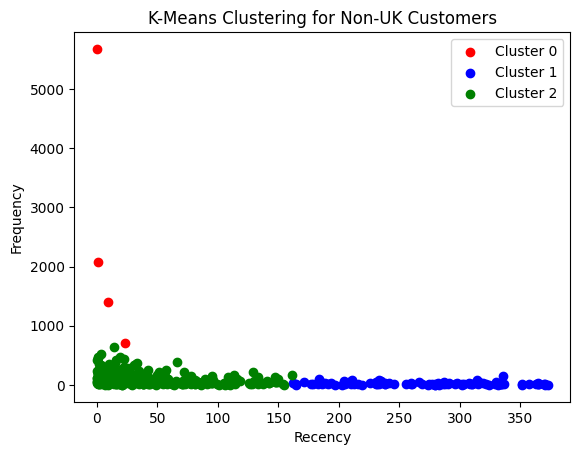

In [ ]:
# Plot Setiap Cluster Berdasarkan Frequency dan Recency
colors = ['red', 'blue', 'green']

for cluster_num in range(3):
    plt.scatter(X_non_uk[X_non_uk['Cluster'] == cluster_num]['Recency'],
                X_non_uk[X_non_uk['Cluster'] == cluster_num]['Frequency'],
                color=colors[cluster_num],
                label=f'Cluster {cluster_num}')

plt.title('K-Means Clustering for Non-UK Customers')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend()
plt.show()